
# Install fastai dependencies

In [1]:
pip install fastai

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import required libraries from fastai and other necessary modules
from fastai.vision.all import *
# from google.colab import drive
from pathlib import Path
import os

# Download Custom Classification Data From Roboflow

['0', '1']


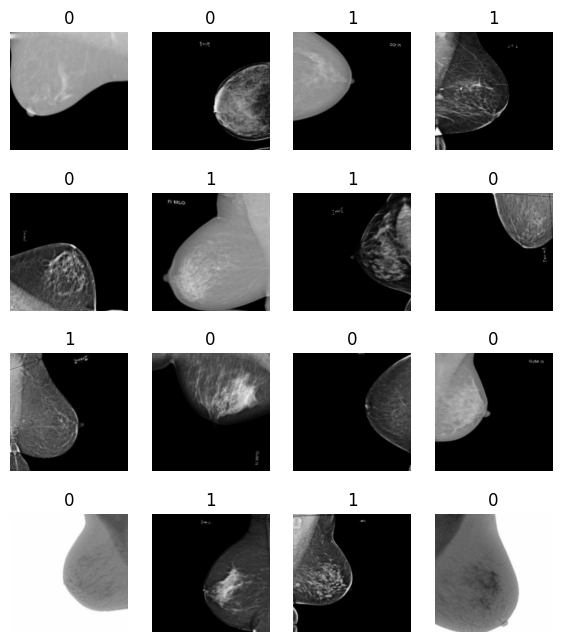

In [3]:
# Define the path to your dataset
dataset_path = './dataset'

# Load the dataset
# Ensure your dataset has '0' and '1' directories representing classes
data = ImageDataLoaders.from_folder(
    dataset_path,
    valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)

# Check data classes
print(data.vocab)

# Visualize a batch of the dataset
data.show_batch(max_n=16, figsize=(7, 8))

# Set up fastai Resnet model

In [4]:
# Create and train the model
learn = vision_learner(data, resnet34, metrics=error_rate)

# Print network layers
print(learn.model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
pip install cuda-python

In [ ]:
pip install gc

# Train Custom Resnet Image Classifier

In [6]:

import torch
import gc

# Callbacks for early stopping and saving the best model
early_stop = EarlyStoppingCallback(monitor='error_rate', patience=20)
save_best_model = SaveModelCallback(monitor='error_rate', fname='best_resnet34')


torch.cuda.empty_cache()
gc.collect()
# def clear_gpu_memory():
#     torch.cuda.empty_cache()
#     gc.collect()
#     del variables

# Use CUDA if available, otherwise use CPU
if torch.cuda.is_available():
    # clear_gpu_memory()
    learn.dls.cuda()
    print("Using GPU (CUDA)")
    learn.fit_one_cycle(10, cbs=[early_stop, save_best_model])
else:
    learn.dls.cpu()
    print("Using CPU")

# Train with frozen layers

Using GPU (CUDA)


epoch,train_loss,valid_loss,error_rate,time
0,0.662947,0.718028,0.354839,00:03
1,0.656172,0.699638,0.333333,00:03
2,0.639749,0.659488,0.293907,00:03
3,0.634205,0.682130,0.308244,00:03
4,0.610728,0.651144,0.318996,00:03
5,0.604982,0.614058,0.286738,00:03
6,0.586977,0.614903,0.279570,00:03
7,0.579480,0.606988,0.286738,00:03
8,0.560255,0.603440,0.286738,00:03
9,0.547328,0.602787,0.290323,00:03


Better model found at epoch 0 with error_rate value: 0.35483869910240173.
Better model found at epoch 1 with error_rate value: 0.3333333432674408.
Better model found at epoch 2 with error_rate value: 0.2939068078994751.
Better model found at epoch 5 with error_rate value: 0.2867383658885956.
Better model found at epoch 6 with error_rate value: 0.2795698940753937.


In [7]:
# Load best model from frozen training
learn.load('best_resnet34')

# Unfreeze the model
learn.unfreeze()

# Function to find the appropriate learning rate
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    # Run the Learning Rate Finder
    model.lr_find()

    # Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    min_loss_index = np.argmin(losses)

    # Get learning rates
    lrs = model.recorder.lrs

    # Return the learning rate that produces the minimum loss divided by 10
    return lrs[min_loss_index] / 10

/home/samad/data-science/virtualenvname/lib/python3.8/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,error_rate,time
0,0.520626,0.606812,0.290323,00:04
1,0.522850,0.608614,0.293907,00:04
2,0.521124,0.607850,0.293907,00:04
3,0.514029,0.607681,0.283154,00:04
4,0.506890,0.609516,0.301075,00:04
5,0.502866,0.611654,0.293907,00:04
6,0.509356,0.607154,0.293907,00:04
7,0.514719,0.609855,0.297491,00:04
8,0.506921,0.604537,0.304659,00:04
9,0.510476,0.610779,0.293907,00:04


Better model found at epoch 0 with error_rate value: 0.29032257199287415.
Better model found at epoch 3 with error_rate value: 0.28315412998199463.
No improvement since epoch 3: early stopping


Path('dataset/models/resnet34.pth')

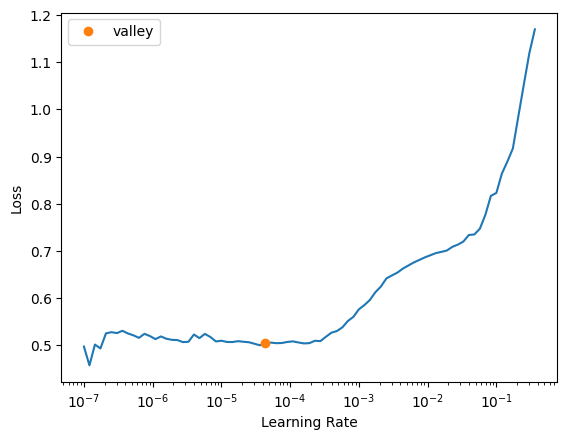

In [8]:
# Find the optimal learning rate
optimal_lr = find_appropriate_lr(learn)

# Fine-tune the model with the optimal learning rate
learn.unfreeze()
learn.fit_one_cycle(100, lr_max=slice(optimal_lr/10, optimal_lr), cbs=[early_stop, save_best_model])

# Load the best model after fine-tuning
learn.load('best_resnet34')

learn.save('resnet34')

# Evaluate Classifier Performance

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       129
           1       0.75      0.71      0.73       150

    accuracy                           0.72       279
   macro avg       0.72      0.72      0.72       279
weighted avg       0.72      0.72      0.72       279



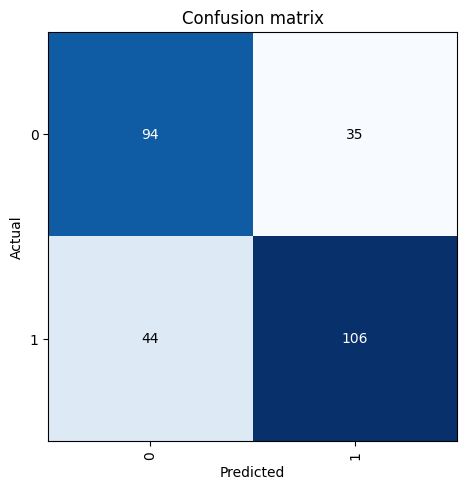

In [11]:
# Evaluate the classifier performance
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# print performance matrix
interp.print_classification_report()

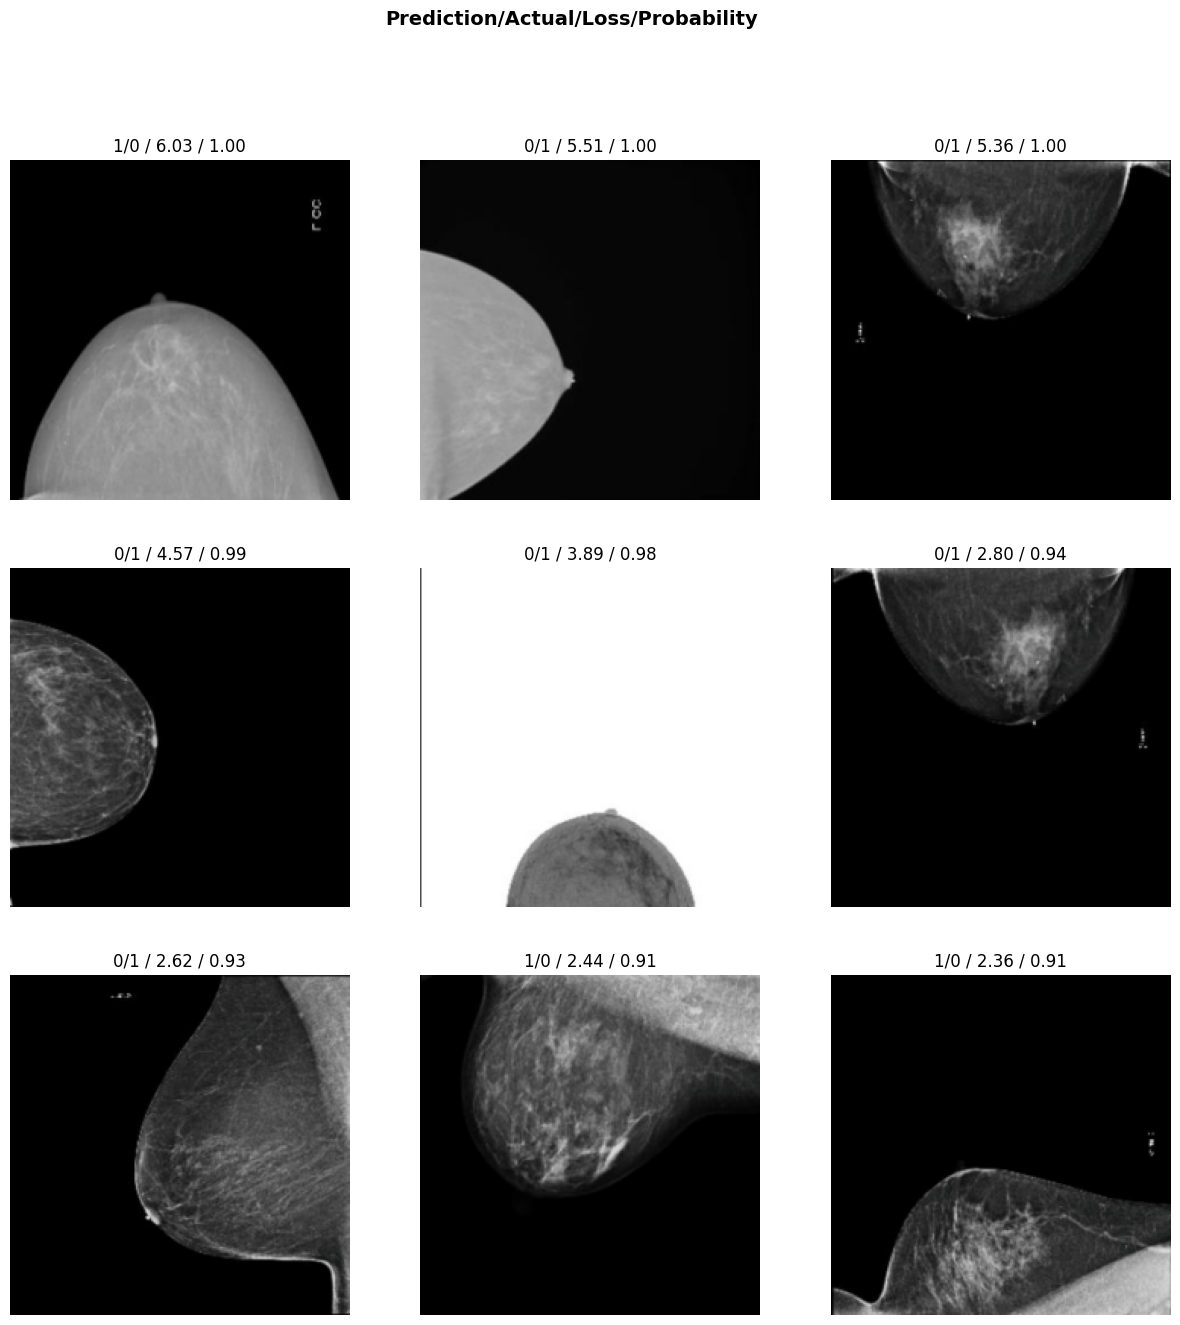

In [10]:
interp.plot_top_losses(9, figsize=(15, 15))

In [19]:
from fastai.vision.all import PILImage

# Run inference on test images
import glob
from IPython.display import Image, display

image_paths = glob.glob('./dataset/0/*.jpg')
print(image_paths)

sumC = 0
total = 0
accuracy = 0

for image_path in image_paths:
    img = PILImage.create(image_path)
    prediction = learn.predict(img)
    if prediction[0] == '1':
        sumC += 1

total = len(image_paths)
accuracy = sumC/total * 100
print("Total: ", total)
print("Correct: ", sumC)
print("Accuracy: ", accuracy)



['./dataset/0/0_506.jpg', './dataset/0/0_141.jpg', './dataset/0/0_172.jpg', './dataset/0/0_271.jpg', './dataset/0/0_374.jpg', './dataset/0/0_103.jpg', './dataset/0/0_344.jpg', './dataset/0/0_368.jpg', './dataset/0/0_450.jpg', './dataset/0/0_006.jpg', './dataset/0/0_363.jpg', './dataset/0/0_342.jpg', './dataset/0/0_317.jpg', './dataset/0/0_443.jpg', './dataset/0/0_333.jpg', './dataset/0/0_198.jpg', './dataset/0/0_216.jpg', './dataset/0/0_078.jpg', './dataset/0/0_157.jpg', './dataset/0/0_361.jpg', './dataset/0/0_136.jpg', './dataset/0/0_373.jpg', './dataset/0/0_296.jpg', './dataset/0/0_416.jpg', './dataset/0/0_292.jpg', './dataset/0/0_598.jpg', './dataset/0/0_278.jpg', './dataset/0/0_545.jpg', './dataset/0/0_536.jpg', './dataset/0/0_045.jpg', './dataset/0/0_282.jpg', './dataset/0/0_232.jpg', './dataset/0/0_286.jpg', './dataset/0/0_030.jpg', './dataset/0/0_538.jpg', './dataset/0/0_061.jpg', './dataset/0/0_421.jpg', './dataset/0/0_425.jpg', './dataset/0/0_314.jpg', './dataset/0/0_395.jpg',

Total:  600
Correct:  60
Accuracy:  10.0


# Save custom classification model for future use

In [ ]:
# Save custom classification model for future use
!ls models/

# Download the model file
from google.colab import files
files.download('./models/best_resnet34.pth')